In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yiweilu2033/well-documented-alzheimers-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.02G/4.02G [01:45<00:00, 40.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yiweilu2033/well-documented-alzheimers-dataset/versions/2


In [ ]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
               print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


VeryMildDemented: 13796 imágenes
MildDemented: 5184 imágenes
NonDemented (2): 63560 imágenes
ModerateDemented: 376 imágenes


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Ruta base del dataset
base_dir = path  # Asegúrate de que 'path' esté definido correctamente

# Actualizamos las clases
alzheimer_classes = ["MildDemented", "VeryMildDemented", "ModerateDemented"]
non_alzheimer_classes = ["NonDemented (2)"]

# Listas para guardar la info
image_paths = []
patient_ids = []
binary_labels = []

# Procesar todas las clases
for category in alzheimer_classes + non_alzheimer_classes:
    # En NonDemented, la subcarpeta se llama "NonDemented"
    subfolder = "NonDemented" if "NonDemented" in category else category
    category_path = os.path.join(base_dir, category, subfolder)

    if not os.path.exists(category_path):
        print(f"Advertencia: No se encontró la carpeta {category_path}, se omitirá.")
        continue

    for img_name in os.listdir(category_path):
        if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            patient_id = "_".join(img_name.split("_")[:3])
            label = "Alzheimer" if category in alzheimer_classes else "NonAlzheimer"

            image_paths.append(os.path.join(category_path, img_name))
            patient_ids.append(patient_id)
            binary_labels.append(label)

# Crear DataFrame
images_df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": binary_labels
})

# Etiquetas únicas por paciente
patient_labels = images_df.groupby('patient_id')['label'].first()

# División estratificada por paciente
unique_patient_ids = images_df["patient_id"].unique()

train_patient_ids, test_patient_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42, stratify=patient_labels.loc[unique_patient_ids]
)

train_patient_ids, val_patient_ids = train_test_split(
    train_patient_ids, test_size=0.2, random_state=42, stratify=patient_labels.loc[train_patient_ids]
)

# Subconjuntos
train_data = images_df[images_df["patient_id"].isin(train_patient_ids)]
val_data = images_df[images_df["patient_id"].isin(val_patient_ids)]
test_data = images_df[images_df["patient_id"].isin(test_patient_ids)]

# Mostrar tamaños
print(f"Tamaño de entrenamiento: {len(train_data)}")
print(f"Tamaño de validación: {len(val_data)}")
print(f"Tamaño de prueba: {len(test_data)}")

# DataFrame final con el conjunto asignado
final_df = images_df.copy()
final_df["set"] = final_df["patient_id"].apply(
    lambda pid: "train" if pid in train_patient_ids else ("val" if pid in val_patient_ids else "test")
)

print(final_df.head())


Tamaño de entrenamiento: 52832
Tamaño de validación: 13481
Tamaño de prueba: 16603
                                          image_path     patient_id  \
0  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0122_MR1   
1  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0382_MR1   
2  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0425_MR1   
3  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0122_MR1   
4  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0405_MR1   

       label    set  
0  Alzheimer    val  
1  Alzheimer   test  
2  Alzheimer   test  
3  Alzheimer    val  
4  Alzheimer  train  


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Transformaciones (iguales para todos los conjuntos)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Etiquetas binarias: Alzheimer / NonAlzheimer
label_to_idx = {"NonAlzheimer": 0, "Alzheimer": 1}

# Dataset personalizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_idx = label_to_idx[label]
        return image, label_idx

# Separar DataFrames
train_df = final_df[final_df["set"] == "train"]
val_df = final_df[final_df["set"] == "val"]
test_df = final_df[final_df["set"] == "test"]

# Datasets
train_dataset = AlzheimerDataset(train_df, transform=transform)
val_dataset = AlzheimerDataset(val_df, transform=transform)
test_dataset = AlzheimerDataset(test_df, transform=transform)

# DataLoaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(AlzheimerCNN, self).__init__()

        # Bloque 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcular el tamaño de entrada para la capa densa
        self.flattened_size = self._get_flattened_size()

        # Capas densas
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)  # Ajustado a 3 clases
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self):
        """Calcula automáticamente el tamaño de la salida antes de la capa fully connected."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # Imagen de ejemplo
            x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
            x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN(num_classes=2).to(device)  # Se pasa el nuevo número de clases
print(model)


AlzheimerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from google.colab import files

# 1. Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Función para entrenar el modelo (SIN Early Stopping)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_preds

        # Evaluación en validación
        model.eval()
        running_val_loss = 0.0
        correct_preds_val = 0
        total_preds_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct_preds_val += torch.sum(preds == labels)
                total_preds_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_preds_val / total_preds_val

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Guardar el mejor modelo basado en la pérdida de validación
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f" Mejor modelo guardado en la época {epoch+1} con val_loss: {epoch_val_loss:.4f}")

        # Imprimir resultados de la época
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f} - "
              f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

    return train_losses, val_losses, val_accuracies

# 3. Función para evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    correct_preds_test = 0
    total_preds_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct_preds_test += torch.sum(preds == labels)
            total_preds_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_preds_test / total_preds_test
    print(f"Test Accuracy: {test_accuracy:.4f}")

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy (sklearn): {accuracy:.4f}")

    return accuracy

# 4. Entrenar el modelo (SIN Early Stopping)
num_epochs = 25
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# 5. Evaluación final en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)

# 6. Guardar el mejor modelo entrenado
model_save_path = "modelo2binario.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en {model_save_path}")
files.download(model_save_path)


 Mejor modelo guardado en la época 1 con val_loss: 0.4032
Epoch 1/25 - Train Loss: 0.3509, Train Accuracy: 0.8292 - Validation Loss: 0.4032, Validation Accuracy: 0.7841
Epoch 2/25 - Train Loss: 0.2766, Train Accuracy: 0.8630 - Validation Loss: 0.4787, Validation Accuracy: 0.7774
Epoch 3/25 - Train Loss: 0.2477, Train Accuracy: 0.8820 - Validation Loss: 0.4921, Validation Accuracy: 0.7716
Epoch 4/25 - Train Loss: 0.2166, Train Accuracy: 0.9004 - Validation Loss: 0.5467, Validation Accuracy: 0.7704
Epoch 5/25 - Train Loss: 0.1825, Train Accuracy: 0.9199 - Validation Loss: 0.6107, Validation Accuracy: 0.7724
Epoch 6/25 - Train Loss: 0.1620, Train Accuracy: 0.9296 - Validation Loss: 0.6980, Validation Accuracy: 0.7634
Epoch 7/25 - Train Loss: 0.1423, Train Accuracy: 0.9387 - Validation Loss: 0.6646, Validation Accuracy: 0.7656
Epoch 8/25 - Train Loss: 0.1291, Train Accuracy: 0.9460 - Validation Loss: 0.6705, Validation Accuracy: 0.7677
Epoch 9/25 - Train Loss: 0.1153, Train Accuracy: 0.952

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

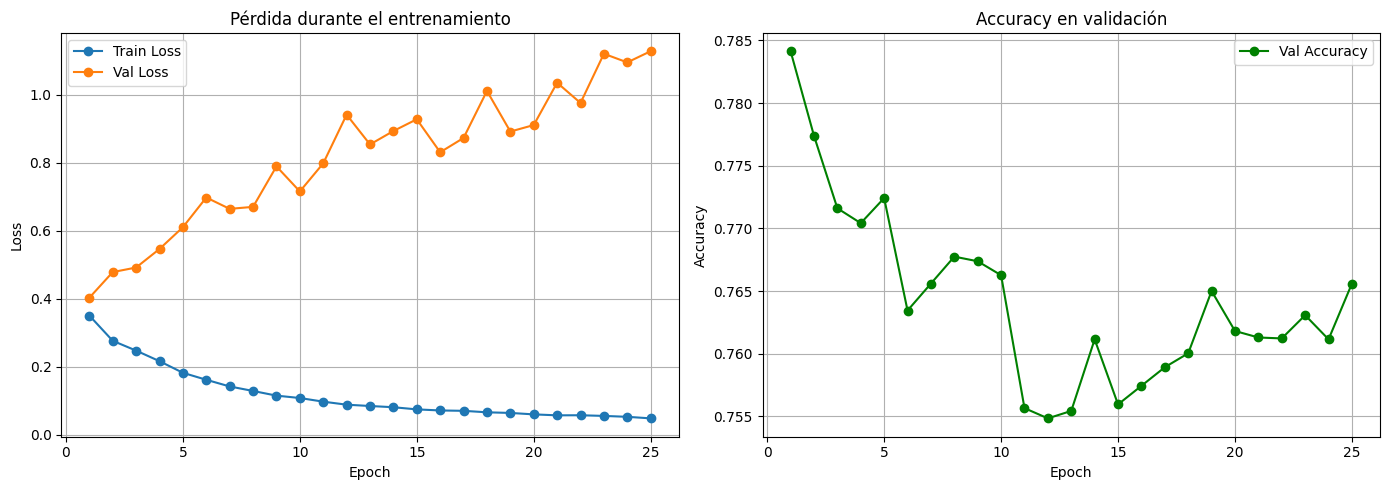

In [ ]:
# Curvas de entrenamiento y validación
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(14, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc.cpu().numpy() for acc in val_accuracies], label="Val Accuracy", color="green", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy en validación")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


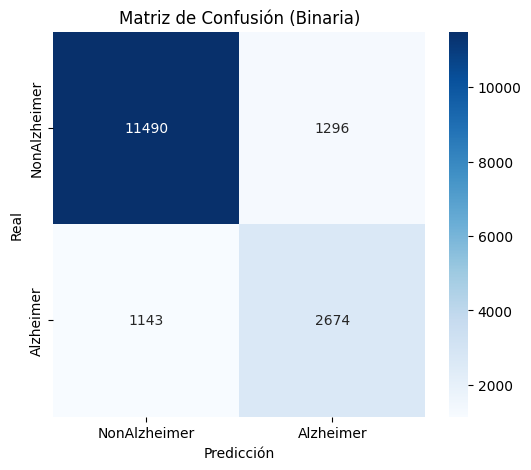

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluar el modelo en el conjunto de prueba
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Etiquetas binarias: 0 = NonAlzheimer, 1 = Alzheimer
label_names = ["NonAlzheimer", "Alzheimer"]
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Binaria)")
plt.show()


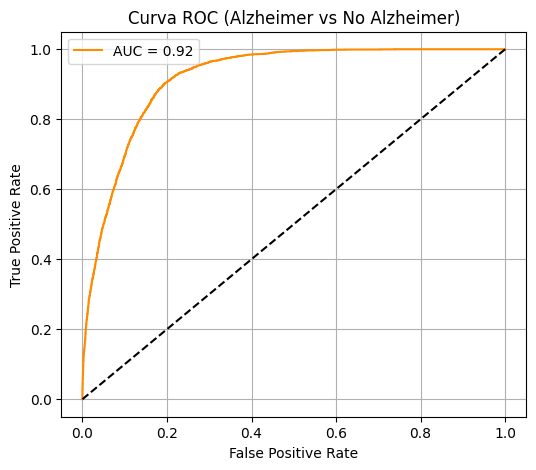

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Obtener los puntajes del modelo (logits sin softmax)
y_scores = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_scores.extend(outputs[:, 1].cpu().numpy())  # puntuaciones para clase "Alzheimer"

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (Alzheimer vs No Alzheimer)")
plt.legend()
plt.grid(True)
plt.show()
